## Imports and Setup
Imports libraries, sets random seeds for reproducibility, and configures CUDA device.

In [1]:
# Import libraries for data handling, deep learning, and visualization
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from collections import defaultdict
import copy
import warnings

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Ignore all warnings
warnings.filterwarnings("ignore")

/home/lms-02/miniconda3/envs/mss-env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Face Dataset Class
Defines `FaceDataset` for loading training images and labels, mapping identities to indices. Handles errors by returning a blank image.

In [2]:
class FaceDataset(Dataset):
    """Custom Dataset for loading face images and labels."""
    
    def __init__(self, image_paths, labels, root_dir, transform=None):
        """
        Args:
            image_paths (list): List of image file paths relative to root_dir (e.g., 'n000001/img1.jpg').
            labels (list): List of corresponding identity labels (e.g., 'n000001').
            root_dir (str): Root directory containing images (e.g., 'project/train').
            transform (callable, optional): Transformations to apply to images.
        """
        self.image_paths = image_paths
        self.labels = labels
        self.root_dir = root_dir
        self.transform = transform
        # Map labels to indices (0 to num_classes-1)
        self.label_map = {label: idx for idx, label in enumerate(sorted(set(labels)))}
        self.num_classes = len(self.label_map)
    
    def __len__(self):
        """Return the total number of samples."""
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        """Load and return an image-label pair."""
        img_path = os.path.join(self.root_dir, self.image_paths[idx])
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            # Return a blank image and label to avoid crashing
            image = Image.new('RGB', (224, 224), (0, 0, 0))
            return torch.zeros(3, 224, 224), self.label_map[self.labels[idx]]
        
        label = self.label_map[self.labels[idx]]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

## Data Transforms
Defines training augmentations (flip, rotation, jitter) and validation/test normalization (resize, ImageNet mean/std).

In [3]:
def get_transforms():
    """Define augmentation and normalization transforms for train, val, and test."""
    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize to 224x224
        transforms.RandomHorizontalFlip(p=0.5),  # 50% chance of flipping
        transforms.RandomRotation(15),  # Rotate by up to 15 degrees
        transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Adjust brightness/contrast
        transforms.ToTensor(),  # Convert to tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
    ])
    
    val_test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    return train_transform, val_test_transform

## Data Splits
Creates 80/15/5 stratified split (~112,000 train, ~21,000 val, ~7,000 test) using `train_test_split` with stratification.

In [4]:
def create_data_splits(root_dir, train_dir='train', val_size=0.15, test_size=0.05):
    """
    Create train, val, and test splits from the training dataset.
    
    Args:
        root_dir (str): Path to dataset directory (e.g., 'project').
        train_dir (str): Subdirectory containing training data (e.g., 'train').
        
    Returns:
        dict: Contains image paths and labels for train, val, and test splits.
    """
    # Collect all image paths and labels
    image_paths = []
    labels = []
    
    train_path = os.path.join(root_dir, train_dir)
    if not os.path.exists(train_path):
        raise FileNotFoundError(f"Training directory {train_path} not found")
    
    for identity in os.listdir(train_path):
        identity_path = os.path.join(train_path, identity)
        if os.path.isdir(identity_path):
            for img_name in os.listdir(identity_path):
                if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                    image_paths.append(os.path.join(identity, img_name))
                    labels.append(identity)
    
    if not image_paths:
        raise ValueError("No images found in training directory")
    
    # First split: 80% train, 20% (val + test)
    train_paths, temp_paths, train_labels, temp_labels = train_test_split(
        image_paths, labels, test_size=(val_size + test_size), stratify=labels, random_state=42
    )
    
    # Second split: Split 20% into 15% val, 5% test (0.75 val, 0.25 test of the 20%)
    val_size_adjusted = val_size / (val_size + test_size)  # 0.15 / (0.15 + 0.05) = 0.75
    val_paths, test_paths, val_labels, test_labels = train_test_split(
        temp_paths, temp_labels, test_size=(1 - val_size_adjusted), stratify=temp_labels, random_state=42
    )
    
    print(f"Train samples: {len(train_paths)}, Val samples: {len(val_paths)}, Test samples: {len(test_paths)}")
    
    return {
        'train': (train_paths, train_labels),
        'val': (val_paths, val_labels),
        'test': (test_paths, test_labels)
    }

## DataLoaders
Creates `DataLoaders` for train, validation, and test sets with specified batch sizes (64 for InceptionResnetV1, 64 for EfficientNet-B0).

In [5]:
def get_dataloaders(root_dir, batch_size=32):
    """
    Create DataLoaders for train, val, and test sets.
    
    Args:
        root_dir (str): Path to dataset directory.
        batch_size (int): Number of samples per batch.
        
    Returns:
        dict: DataLoaders for train, val, and test.
        int: Number of classes.
    """
    # Get transforms
    train_transform, val_test_transform = get_transforms()
    
    # Create splits
    splits = create_data_splits(root_dir)
    
    # Initialize datasets
    train_path = os.path.join(root_dir, 'train')  # Full path for train folder
    datasets = {
        'train': FaceDataset(splits['train'][0], splits['train'][1], train_path, train_transform),
        'val': FaceDataset(splits['val'][0], splits['val'][1], train_path, val_test_transform),
        'test': FaceDataset(splits['test'][0], splits['test'][1], train_path, val_test_transform)
    }
    
    # Create DataLoaders
    dataloaders = {
        'train': DataLoader(datasets['train'], batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True),
        'val': DataLoader(datasets['val'], batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True),
        'test': DataLoader(datasets['test'], batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
    }
    
    return dataloaders, datasets['train'].num_classes

## Test Dataset Class
Defines `TestDataset` for loading test images, returning image tensors and filenames for submission.

In [6]:
class TestDataset(Dataset):
    """Dataset for test images without labels."""
    
    def __init__(self, image_paths, root_dir, transform=None):
        """
        Args:
            image_paths (list): List of image file names (e.g., '1.jpg').
            root_dir (str): Directory containing test images (e.g., 'project/test').
            transform (callable, optional): Transformations to apply.
        """
        self.image_paths = image_paths
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.image_paths[idx])
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading test image {img_path}: {e}")
            image = Image.new('RGB', (224, 224), (0, 0, 0))
            return torch.zeros(3, 224, 224), self.image_paths[idx]
        
        img_name = self.image_paths[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, img_name

In [ ]:
class FaceClassifier(nn.Module):
    """CNN-based face classifier."""
    
    def __init__(self, backbone='resnet50', num_classes=7000, dropout_rate=0.5):
        """
        Args:
            backbone (str): Pre-trained backbone ('resnet50', 'efficientnet_b0', 'googlenet', 'xception', 'vgg16').
            num_classes (int): Number of classes.
            dropout_rate (float): Dropout rate.
        """
        super(FaceClassifier, self).__init__()
        
        if backbone == 'resnet50':
            self.backbone = models.resnet50(pretrained=True)
            in_features = self.backbone.fc.in_features
            self.backbone.fc = nn.Identity()
        elif backbone == 'efficientnet_b0':
            self.backbone = models.efficientnet_b0(pretrained=True)
            in_features = self.backbone.classifier[1].in_features
            self.backbone.classifier = nn.Identity()
        elif backbone == 'googlenet':
            self.backbone = models.googlenet(pretrained=True)
            in_features = self.backbone.fc.in_features
            self.backbone.fc = nn.Identity()
        elif backbone == 'xception':
            try:
                from torchvision.models import xception
                self.backbone = xception(pretrained=True)
                in_features = self.backbone.fc.in_features
                self.backbone.fc = nn.Identity()
            except ImportError:
                raise ValueError("Xception not available in torchvision. Consider installing timm or skipping.")
        elif backbone == 'vgg16':
            self.backbone = models.vgg16(pretrained=True)
            in_features = 512 * 7 * 7
            self.backbone.classifier = nn.Identity()
            self.backbone.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        else:
            raise ValueError("Unsupported backbone!")
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.BatchNorm1d(512),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        features = self.backbone(x)
        return self.classifier(features)

## Training Function
Trains the model for 15 epochs, saves best weights based on validation accuracy, and tracks loss/accuracy history.

In [8]:
def train_model(model, model_name, dataloaders, criterion, optimizer, num_epochs=10, device='cuda'):
    """
    Train the model and monitor performance.
    
    Args:
        model (nn.Module): The neural network model.
        dataloaders (dict): DataLoaders for train and val.
        criterion: Loss function.
        optimizer: Optimization algorithm.
        num_epochs (int): Number of epochs.
        device (str): Device to run on ('cuda' or 'cpu').
        
    Returns:
        dict: Training history (losses and accuracies).
    """
    model.to(device)
    history = defaultdict(list)
    save_path = f"{model_name}_best.pth"
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

                torch.save(best_model_wts, save_path)
                print(f"Saved best model to {save_path}")
        
        print()
    
    model.load_state_dict(best_model_wts)
    return history

## Plot Training Curves
Plots training and validation loss/accuracy curves for model performance visualization.

In [9]:
def plot_training_curves(model_name, history):
    """Plot training and validation loss/accuracy curves."""
    epochs = range(1, len(history['train_loss']) + 1)
    
    plt.figure(figsize=(12, 5))
    plt.suptitle(f'{model_name}')
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Val Loss')
    plt.title('Loss vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Train Acc')
    plt.plot(epochs, history['val_acc'], label='Val Acc')
    plt.title('Accuracy vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

## Submission Function
Generates `submission.csv` for test images using the trained model, saving to the specified directory.

In [10]:
def generate_submission(model, root_dir, submission_name='submission.csv', test_dir='test', device='cuda'):
    """
    Generate predictions for the test set and save to CSV.
    
    Args:
        model (nn.Module): Trained model.
        root_dir (str): Dataset directory (e.g., 'project').
        test_dir (str): Test subdirectory (e.g., 'test').
        device (str): Device to run on.
    """
    # Get test transform
    _, test_transform = get_transforms()
    
    # Load test images
    test_path = os.path.join(root_dir, test_dir)
    if not os.path.exists(test_path):
        raise FileNotFoundError(f"Test directory {test_path} not found")
    
    test_image_paths = sorted([f for f in os.listdir(test_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
    
    if not test_image_paths:
        raise ValueError("No images found in test directory")
    
    # Create test dataset and DataLoader
    test_dataset = TestDataset(test_image_paths, test_path, test_transform)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)
    
    # Load label map from training dataset
    train_paths, train_labels = create_data_splits(root_dir)['train']
    train_dataset = FaceDataset(train_paths, train_labels, os.path.join(root_dir, 'train'))
    label_map = {idx: label for label, idx in train_dataset.label_map.items()}
    
    model.eval()
    model.to(device)
    
    predictions = []
    image_names = []
    
    with torch.no_grad():
        for inputs, names in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for pred, name in zip(preds, names):
                predictions.append(label_map[pred.item()])
                image_names.append(name)
    
    # Create submission DataFrame
    submission_df = pd.DataFrame({'image_name': image_names, 'label': predictions})
    submission_df.to_csv(submission_name, index=False)
    print(f"Submission file created: {submission_name}")

## Train EfficientNet-B0
Initializes EfficientNet-B0, trains for 15 epochs, plots curves, and generates submission. Uses batch size 64.

cuda
Train samples: 112000, Val samples: 20999, Test samples: 7001
Number of classes: 7000
Training efficientnet_b0...
Epoch 1/15
----------
train Loss: 7.9036 Acc: 0.0062
val Loss: 6.4090 Acc: 0.0291
Saved best model to efficientnet_best.pth

Epoch 2/15
----------
train Loss: 6.1353 Acc: 0.0418
val Loss: 4.9720 Acc: 0.1217
Saved best model to efficientnet_best.pth

Epoch 3/15
----------
train Loss: 4.9113 Acc: 0.1238
val Loss: 3.9639 Acc: 0.2506
Saved best model to efficientnet_best.pth

Epoch 4/15
----------
train Loss: 3.9735 Acc: 0.2325
val Loss: 3.2762 Acc: 0.3737
Saved best model to efficientnet_best.pth

Epoch 5/15
----------
train Loss: 3.2718 Acc: 0.3337
val Loss: 2.8163 Acc: 0.4530
Saved best model to efficientnet_best.pth

Epoch 6/15
----------
train Loss: 2.7480 Acc: 0.4204
val Loss: 2.5417 Acc: 0.5088
Saved best model to efficientnet_best.pth

Epoch 7/15
----------
train Loss: 2.3622 Acc: 0.4898
val Loss: 2.2788 Acc: 0.5594
Saved best model to efficientnet_best.pth

Epoch 

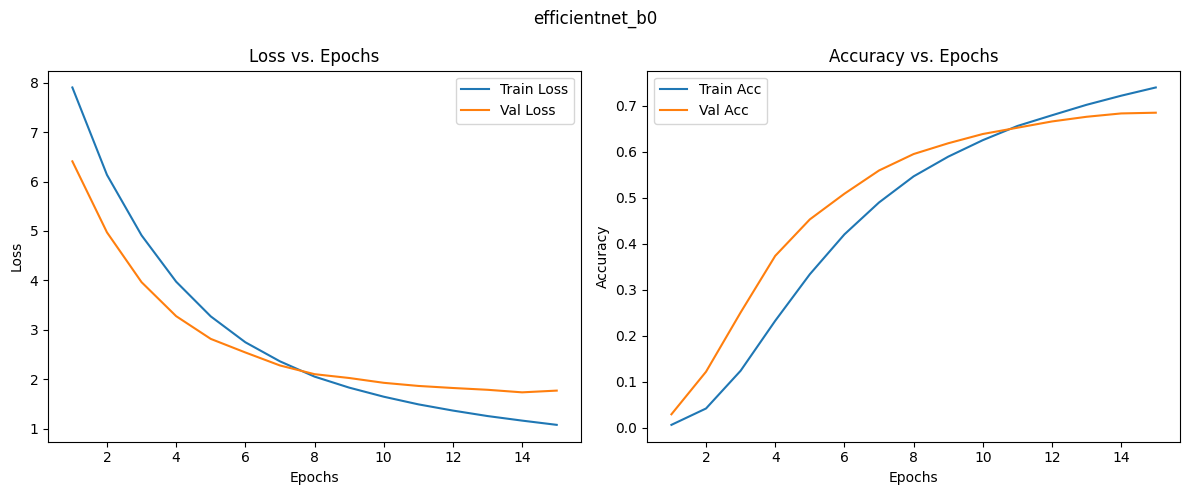

Error generating submission: generate_submission() got an unexpected keyword argument 'submission_dir'
efficientnet_b0 Best Val Acc: 0.6850


In [33]:
def main():
    backbone='efficientnet_b0'
    root_dir = '/data/Face_Classification_Dataset/' 
    submission_name = 'efficientnet_b0_submission.csv'
    batch_size = 64
    num_epochs = 15 
    learning_rate = 0.001
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(device)
    
    # Get DataLoaders and number of classes
    try:
        dataloaders, num_classes = get_dataloaders(root_dir, batch_size)
        print(f"Number of classes: {num_classes}")
    except Exception as e:
        print(f"Error creating DataLoaders: {e}")
        return

    criterion = nn.CrossEntropyLoss()
    
    # Train and evaluate efficientnet_b0
    print("Training efficientnet_b0...")
    efficientnet_b0_model = FaceClassifier(backbone, num_classes=num_classes)
    optimizer = optim.Adam(efficientnet_b0_model.parameters(), lr=learning_rate)
    efficientnet_b0_history = train_model(efficientnet_b0_model, model_name=backbone, dataloaders, criterion, optimizer, num_epochs, device)
    
    # Plot efficientnet_b0 training curves
    plot_training_curves(backbone, efficientnet_b0_history)
    
    # Generate submission 
    try:
        generate_submission(efficientnet_b0_model, root_dir, submission_name)
    except Exception as e:
        print(f"Error generating submission: {e}")
    
    print(f"efficientnet_b0 Best Val Acc: {max(efficientnet_b0_history['val_acc']):.4f}")

if __name__ == '__main__':
    main()

## Conclusion:

### Left Plot: Loss vs. Epochs
Training Loss starts high (~8.0) and decreases consistently to ~1.1.

Validation Loss also drops significantly, from ~6.5 to ~1.7, and stays fairly stable after epoch 8.

#### Interpretation:

Both curves show good convergence.

No significant divergence between training and validation loss → low overfitting.

A very small uptick in validation loss around epoch 14–15, but it's minor.

### Right Plot: Accuracy vs. Epochs
Training Accuracy rises gradually from ~0.01 to ~0.74.

Validation Accuracy increases quickly early on, surpasses training accuracy until ~epoch 11, and then both converge around 0.70–0.72.

#### Interpretation:

Validation accuracy being higher than training accuracy for much of the training is unusual but not impossible — this can happen due to:

Regularization (like dropout) making training slightly harder

Data augmentation applied only to the training set

Smaller validation set (leading to less variability)

In [ ]:
if __name__ == '__main__':
    
    num_classes = 7000
    model_name = 'efficientnet_b0'
    submission_name = 'efficientnet_b0_submission.csv'
    root_dir = '/data/Face_Classification_Dataset/' 
    model_path = '/model/efficientnet_best.pth'
    submission_dir = '/submissions/'
    
    model = FaceClassifier(backbone=model_name, num_classes=num_classes)
    
    # Load saved weights
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model weights not found at {model_path}")
    model.load_state_dict(torch.load(model_path))
    print(f"Loaded model weights from {model_path}")
    
    # Generate submission
    generate_submission(model, root_dir, submission_name)

Loaded model weights from /home/lms-02/face_classification/abubakar/efficientnet_best.pth
Train samples: 112000, Val samples: 20999, Test samples: 7001
Submission file created: efficientnet_b0_submission.csv


## Train InceptionResnetV1
Initializes InceptionResnetV1 (VGGFace2 pre-trained), freezes all but last 15 layers, trains for 10 epochs, plots curves, and generates submission. Uses batch size 64.

In [ ]:
def main():

    model_name = 'InceptionResnetV1'
    root_dir = '/data/Face_Classification_Dataset/' 
    submission_dir = '/submissions/'
    submission_name = os.path.join(submission_dir, 'inceptionresnetv1_submission.csv')
    num_epochs = 10
    learning_rate = 0.001
    batch_size = 64
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(device)
    
    # Get DataLoaders and number of classes
    try:
        dataloaders, num_classes = get_dataloaders(root_dir, batch_size)
        print(f"Number of classes: {num_classes}")
    except Exception as e:
        print(f"Error creating DataLoaders: {e}")
        return
    
    # Initialize model
    model = InceptionResnetV1(pretrained='vggface2', device=device, classify=True, num_classes=num_classes)
    
    # Freeze all parameters
    for param in model.parameters():
        param.requires_grad = False
    
    # Unfreeze last 15 layers
    layers_to_unfreeze = 15
    for param in list(model.parameters())[-layers_to_unfreeze:]:
        param.requires_grad = True
    
    # Optimizer and loss
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    
    # Train model
    print("\nTraining InceptionResnetV1...")
    history = train_model(model, model_name, dataloaders, criterion, optimizer, num_epochs, device)
    
    if history is None:
        print("Training failed due to memory issues.")
        return
    
    # Plot curves
    plot_training_curves(model_name, history)
    
    # Print final validation accuracy
    val_acc = max(history['val_acc'])
    print(f"InceptionResnetV1: Best Val Acc: {val_acc:.4f}")
    
    # Generate submission
    print(f"\nGenerating submission with InceptionResnetV1 (Val Acc: {val_acc:.4f})")
    generate_submission(model, root_dir, submission_name=submission_name, test_dir='test', device=device)

cuda
Train samples: 112000, Val samples: 20999, Test samples: 7001
Number of classes: 7000

Training InceptionResnetV1...
Epoch 1/10
----------
train Loss: 3.8790 Acc: 0.4228
val Loss: 1.4218 Acc: 0.7725
Saved best model to InceptionResnetV1_best.pth

Epoch 2/10
----------
train Loss: 1.7137 Acc: 0.7050
val Loss: 1.3454 Acc: 0.7892
Saved best model to InceptionResnetV1_best.pth

Epoch 3/10
----------
train Loss: 1.4162 Acc: 0.7512
val Loss: 1.3362 Acc: 0.7895
Saved best model to InceptionResnetV1_best.pth

Epoch 4/10
----------
train Loss: 1.2793 Acc: 0.7734
val Loss: 1.2994 Acc: 0.7928
Saved best model to InceptionResnetV1_best.pth

Epoch 5/10
----------
train Loss: 1.1967 Acc: 0.7848
val Loss: 1.1896 Acc: 0.8228
Saved best model to InceptionResnetV1_best.pth

Epoch 6/10
----------
train Loss: 1.1012 Acc: 0.8006
val Loss: 1.5489 Acc: 0.7400

Epoch 7/10
----------
train Loss: 1.0469 Acc: 0.8082
val Loss: 1.5440 Acc: 0.7416

Epoch 8/10
----------
train Loss: 0.9975 Acc: 0.8166
val Loss:

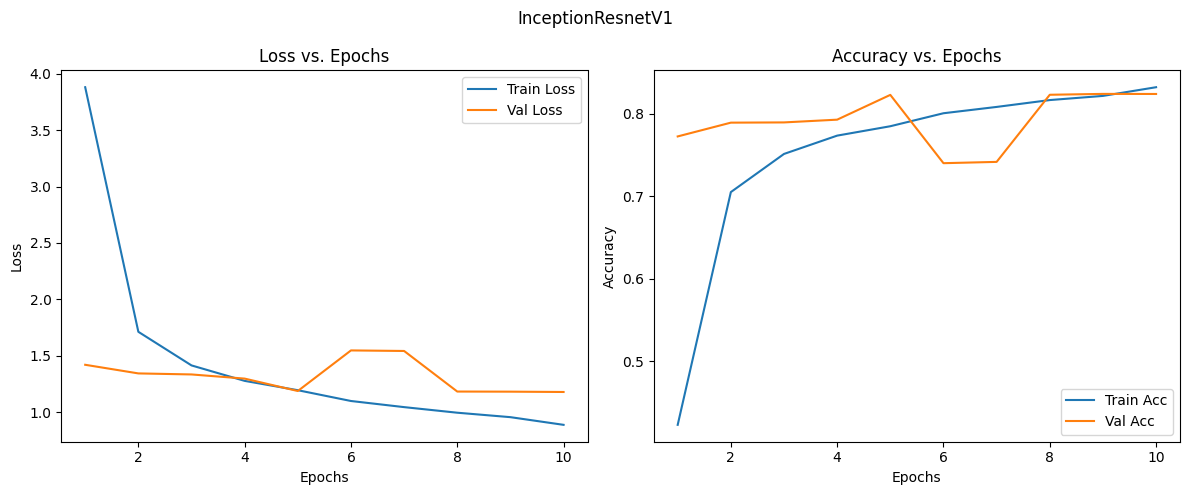

InceptionResnetV1: Best Val Acc: 0.8240

Generating submission with InceptionResnetV1 (Val Acc: 0.8240)
Train samples: 112000, Val samples: 20999, Test samples: 7001
Submission file created: /home/lms-02/face_classification/abubakar/submissions/inceptionresnetv1_submission.csv


In [14]:
if __name__ == '__main__':
    try:
        from facenet_pytorch import InceptionResnetV1
    except ImportError:
        print("Installing facenet-pytorch...")
        os.system('pip install facenet-pytorch')
    
    main()

## Left Plot: Loss vs. Epochs
Training Loss decreases steadily and significantly — from nearly 4.0 to below 1.0.

Validation Loss initially decreases, but then fluctuates between epochs 5 to 8 and plateaus around 1.2.

### Interpretation:

The model learns effectively at first (both losses go down).

Around epoch 6–8, validation loss increases while training loss decreases, indicating possible overfitting starting around that point.

Despite overfitting signs, the final validation loss still ends lower than where it started, so some generalization exists.

## Right Plot: Accuracy vs. Epochs
Training Accuracy rises steadily from ~0.43 to ~0.83.

Validation Accuracy is quite high from the start (~0.78) and fluctuates slightly before stabilizing near 0.82–0.83.

### Interpretation:

The model reaches high accuracy quickly and maintains it.

The training and validation accuracy converge, which is a good sign (no severe overfitting).

Minor dips in validation accuracy around epoch 6–7 align with validation loss increases, but it recovers.